<a href="https://colab.research.google.com/github/pabloinsente/CovNet_Human_Drawings/blob/master/code/model_training_hyperparameter_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install talos

    100% |████████████████████████████████| 51kB 20.8MB/s 
    100% |████████████████████████████████| 778kB 20.3MB/s 
    100% |████████████████████████████████| 12.6MB 3.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/eb/6b/c0/5b58a4767728bb467656ccd70b4fc2e286840c1e8ffa2631ac
  Stored in directory: /root/.cache/pip/wheels/ba/cc/e9/11c6a853d8379f295e17b68f2139ea1bbcd13c5b260822abc7
  Stored in directory: /root/.cache/pip/wheels/61/12/37/957767d4ed95919b90081079c6eb74f83927930e652b30fa93
  Stored in directory: /root/.cache/pip/wheels/36/6b/4c/e1fc6d7d8811940fbea1147b1519c7baa6933e4baeff904433
  Stored in directory: /root/.cache/pip/wheels/ce/ea/67/c7756f897f70f22279c7f2bbf5be52423d85835643042fcc34
Successfully built talos astetik chances kerasplotlib wrangle
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: matplotlib 3.0.3
    Uninstalling matplotlib-3.0.3:
      Successfully uninstalle

In [1]:
import talos as ta
from talos.metrics.keras_metrics import fmeasure_acc
from talos.model.normalizers import lr_normalizer

from keras.activations import relu, elu, sigmoid
from keras.optimizers import Adam, Nadam, RMSprop
from keras.losses import binary_crossentropy, logcosh
from keras.models import Sequential
from keras.layers import Dense, Dropout

from numpy import genfromtxt

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [2]:
# Clone the data into Colab
! git clone https://github.com/pabloinsente/CovNet_Human_Drawings

Cloning into 'CovNet_Human_Drawings'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 584 (delta 25), reused 25 (delta 9), pack-reused 527
Receiving objects: 100% (584/584), 54.96 MiB | 27.96 MiB/s, done.
Resolving deltas: 100% (135/135), done.


In [3]:
# Get data
x_path= 'CovNet_Human_Drawings/data/merged_dataframes_prediction/x_train_drawings_features_max_pool_5_pca.csv'
y_path = 'CovNet_Human_Drawings/data/merged_dataframes_prediction/y_train_age_adult_labels.csv'

x = genfromtxt(x_path, delimiter=',')
y = genfromtxt(y_path, delimiter=',')

print(x.shape) # (258, 200)
print(y.shape) # (258,)

(258, 200)
(258,)


In [4]:
# Split data into train and test sets
# Since we have an small sample, we will do a 70/30 split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=44)
print(x_train.shape) # (180, 200)
print(y_train.shape) # (180,)
print(x_test.shape) # (78, 200)
print(y_test.shape) # (78,)

(180, 200)
(180,)
(78, 200)
(78,)


In [0]:
# define model
def input_model(x_train, y_train, x_val, y_val, params):
  model = Sequential()
  # add hidden layer
  model.add(Dense(params['first_neuron'], 
                  input_dim=x_train.shape[1], 
                  activation=params['activation'],
                  kernel_initializer = params['kernel_initializer']))
  # add dropout layer
  model.add(Dropout(params['dropout']))
  # add output layer
  model.add(Dense(1,activation=params['last_activation'],
                  kernel_initializer = params['kernel_initializer']))
  # compile model
  model.compile(loss=params['losses'],
                optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                metrics=['acc', fmeasure_acc])
  # train model
  out = model.fit(x_train, y_train,
                  validation_data=[x_val, y_val],
                  batch_size=params['batch_size'],
                  # 180*.29 = ~52, which is ~20% of all data
                  #val_split = .29, 
                  epochs=params['epochs'])
  return out, model

In [0]:
# set hyperparameters to optimize
p = {'first_neuron': [4, 8, 16, 32],
     'activation': [relu, sigmoid],
     'optimizer': [Nadam, Adam],
     'losses':[binary_crossentropy],
     'hidden_layers':[0, 1, 2],
     'batch_size': [10, 20, 30],
     'epochs':[4, 10, 20, 40],
     'dropout': [0, 0.1, 0.2],
     'kernel_initializer': ['uniform','normal'],
     'lr':[0.001, 0.01, 0.1],
     'last_activation': ['sigmoid']}

In [7]:
# starting optimization
h = ta.Scan(x= x_train, y=y_train,
            params=p,
            model=input_model,
            grid_downsample=.001)

  0%|          | 0/10 [00:00<?, ?it/s]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 3s 24ms/step - loss: 0.6756 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6745 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 218us/step - loss: 0.6754 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6743 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 215us/step - loss: 0.6752 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6740 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 234us/step - loss: 0.6749 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6738 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+00


 10%|█         | 1/10 [00:03<00:33,  3.68s/it]

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.7165 - acc: 0.2160 - fmeasure_acc: 0.3352 - val_loss: 0.7170 - val_acc: 0.2000 - val_fmeasure_acc: 0.3249
Epoch 2/4
125/125 [==============================] - 0s 773us/step - loss: 0.7149 - acc: 0.2000 - fmeasure_acc: 0.3244 - val_loss: 0.7167 - val_acc: 0.2000 - val_fmeasure_acc: 0.3249
Epoch 3/4
125/125 [==============================] - 0s 532us/step - loss: 0.7132 - acc: 0.2240 - fmeasure_acc: 0.3220 - val_loss: 0.7163 - val_acc: 0.2000 - val_fmeasure_acc: 0.3249
Epoch 4/4
125/125 [==============================] - 0s 552us/step - loss: 0.7165 - acc: 0.2080 - fmeasure_acc: 0.3261 - val_loss: 0.7160 - val_acc: 0.2000 - val_fmeasure_acc: 0.3249


 20%|██        | 2/10 [00:04<00:23,  2.91s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/40
125/125 [==============================] - 0s 3ms/step - loss: 0.6706 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6684 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+00
Epoch 2/40
125/125 [==============================] - 0s 318us/step - loss: 0.6686 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6683 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+00
Epoch 3/40
125/125 [==============================] - 0s 329us/step - loss: 0.6691 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6682 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+00
Epoch 4/40
125/125 [==============================] - 0s 294us/step - loss: 0.6680 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6681 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+00
Epoch 5/40
125/125 [==============================] - 0s 299us/step - loss: 0.6683 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6679 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+

 30%|███       | 3/10 [00:07<00:19,  2.81s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6966 - acc: 0.2880 - fmeasure_acc: 0.3206 - val_loss: 0.6955 - val_acc: 0.2000 - val_fmeasure_acc: 0.3308
Epoch 2/4
125/125 [==============================] - 0s 434us/step - loss: 0.6952 - acc: 0.2720 - fmeasure_acc: 0.2982 - val_loss: 0.6944 - val_acc: 0.2000 - val_fmeasure_acc: 0.3308
Epoch 3/4
125/125 [==============================] - 0s 410us/step - loss: 0.6940 - acc: 0.3440 - fmeasure_acc: 0.3262 - val_loss: 0.6933 - val_acc: 0.3091 - val_fmeasure_acc: 0.3499
Epoch 4/4
125/125 [==============================] - 0s 422us/step - loss: 0.6930 - acc: 0.5120 - fmeasure_acc: 0.2538 - val_loss: 0.6922 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+00


 40%|████      | 4/10 [00:08<00:14,  2.37s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6836 - acc: 0.7920 - fmeasure_acc: 0.0990 - val_loss: 0.6830 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+00
Epoch 2/4
125/125 [==============================] - 0s 371us/step - loss: 0.6805 - acc: 0.8000 - fmeasure_acc: 0.0400 - val_loss: 0.6800 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+00
Epoch 3/4
125/125 [==============================] - 0s 407us/step - loss: 0.6801 - acc: 0.7840 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6767 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+00
Epoch 4/4
125/125 [==============================] - 0s 391us/step - loss: 0.6762 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6734 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+00


 50%|█████     | 5/10 [00:09<00:09,  2.00s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/20
125/125 [==============================] - 0s 3ms/step - loss: 0.6935 - acc: 0.3600 - fmeasure_acc: 0.2935 - val_loss: 0.6934 - val_acc: 0.4364 - val_fmeasure_acc: 0.3566
Epoch 2/20
125/125 [==============================] - 0s 709us/step - loss: 0.6931 - acc: 0.5600 - fmeasure_acc: 0.2168 - val_loss: 0.6930 - val_acc: 0.6727 - val_fmeasure_acc: 0.4190
Epoch 3/20
125/125 [==============================] - 0s 780us/step - loss: 0.6926 - acc: 0.6640 - fmeasure_acc: 0.1853 - val_loss: 0.6926 - val_acc: 0.7273 - val_fmeasure_acc: 0.3152
Epoch 4/20
125/125 [==============================] - 0s 698us/step - loss: 0.6922 - acc: 0.7120 - fmeasure_acc: 0.1467 - val_loss: 0.6922 - val_acc: 0.7273 - val_fmeasure_acc: 0.1212
Epoch 5/20
125/125 [==============================] - 0s 720us/step - loss: 0.6918 - acc: 0.7600 - fmeasure_acc: 0.0400 - val_loss: 0.6918 - val_acc: 0.7818 - val_fmeasure_acc: 0.0000e+00
Epoch 6/20
125/125 [=============

 60%|██████    | 6/10 [00:12<00:09,  2.28s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/10
125/125 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.4880 - fmeasure_acc: 0.3195 - val_loss: 0.6929 - val_acc: 0.6182 - val_fmeasure_acc: 0.3231
Epoch 2/10
125/125 [==============================] - 0s 309us/step - loss: 0.6929 - acc: 0.6640 - fmeasure_acc: 0.3957 - val_loss: 0.6927 - val_acc: 0.6364 - val_fmeasure_acc: 0.2727
Epoch 3/10
125/125 [==============================] - 0s 295us/step - loss: 0.6927 - acc: 0.7280 - fmeasure_acc: 0.3253 - val_loss: 0.6926 - val_acc: 0.6727 - val_fmeasure_acc: 0.1948
Epoch 4/10
125/125 [==============================] - 0s 286us/step - loss: 0.6925 - acc: 0.7760 - fmeasure_acc: 0.2024 - val_loss: 0.6924 - val_acc: 0.7455 - val_fmeasure_acc: 0.1136
Epoch 5/10
125/125 [==============================] - 0s 301us/step - loss: 0.6923 - acc: 0.7680 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6922 - val_acc: 0.7455 - val_fmeasure_acc: 0.0000e+00
Epoch 6/10
125/125 [=========

 70%|███████   | 7/10 [00:13<00:05,  1.95s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/20
125/125 [==============================] - 0s 3ms/step - loss: 0.6935 - acc: 0.3760 - fmeasure_acc: 0.3458 - val_loss: 0.6935 - val_acc: 0.3273 - val_fmeasure_acc: 0.2298
Epoch 2/20
125/125 [==============================] - 0s 695us/step - loss: 0.6935 - acc: 0.3520 - fmeasure_acc: 0.2945 - val_loss: 0.6934 - val_acc: 0.3273 - val_fmeasure_acc: 0.2298
Epoch 3/20
125/125 [==============================] - 0s 725us/step - loss: 0.6934 - acc: 0.3520 - fmeasure_acc: 0.2922 - val_loss: 0.6934 - val_acc: 0.3455 - val_fmeasure_acc: 0.2088
Epoch 4/20
125/125 [==============================] - 0s 709us/step - loss: 0.6933 - acc: 0.4160 - fmeasure_acc: 0.3168 - val_loss: 0.6933 - val_acc: 0.3818 - val_fmeasure_acc: 0.2088
Epoch 5/20
125/125 [==============================] - 0s 711us/step - loss: 0.6933 - acc: 0.4480 - fmeasure_acc: 0.2804 - val_loss: 0.6933 - val_acc: 0.4000 - val_fmeasure_acc: 0.2169
Epoch 6/20
125/125 [=================

 80%|████████  | 8/10 [00:16<00:04,  2.15s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/4
125/125 [==============================] - 0s 3ms/step - loss: 0.6937 - acc: 0.4480 - fmeasure_acc: 0.2650 - val_loss: 0.6947 - val_acc: 0.3273 - val_fmeasure_acc: 0.2744
Epoch 2/4
125/125 [==============================] - 0s 302us/step - loss: 0.6937 - acc: 0.4560 - fmeasure_acc: 0.2883 - val_loss: 0.6947 - val_acc: 0.3273 - val_fmeasure_acc: 0.2744
Epoch 3/4
125/125 [==============================] - 0s 318us/step - loss: 0.6937 - acc: 0.4560 - fmeasure_acc: 0.2427 - val_loss: 0.6947 - val_acc: 0.3273 - val_fmeasure_acc: 0.2744
Epoch 4/4
125/125 [==============================] - 0s 300us/step - loss: 0.6938 - acc: 0.4560 - fmeasure_acc: 0.2593 - val_loss: 0.6947 - val_acc: 0.3273 - val_fmeasure_acc: 0.2744


 90%|█████████ | 9/10 [00:17<00:01,  1.92s/it]

Train on 125 samples, validate on 55 samples
Epoch 1/40
125/125 [==============================] - 0s 3ms/step - loss: 0.6642 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6636 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+00
Epoch 2/40
125/125 [==============================] - 0s 360us/step - loss: 0.6642 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6636 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+00
Epoch 3/40
125/125 [==============================] - 0s 370us/step - loss: 0.6642 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6635 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+00
Epoch 4/40
125/125 [==============================] - 0s 366us/step - loss: 0.6641 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6635 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+00
Epoch 5/40
125/125 [==============================] - 0s 424us/step - loss: 0.6641 - acc: 0.7920 - fmeasure_acc: 0.0000e+00 - val_loss: 0.6635 - val_acc: 0.8000 - val_fmeasure_acc: 0.0000e+

100%|██████████| 10/10 [00:20<00:00,  2.20s/it]


In [8]:
# accessing the results data frame
h.data.head()

,round_epochs,val_loss,val_acc,val_fmeasure_acc,loss,acc,fmeasure_acc,first_neuron,activation,optimizer,losses,hidden_layers,batch_size,epochs,dropout,kernel_initializer,lr,last_activation
0,4,0.673808,0.8,0.000000,0.674917,0.792,0.000000,32,<function sigmoid at 0x7f708d2d8840>,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7f708d326840>,1,30,4,0.0,normal,0.01,sigmoid
1,4,0.715969,0.2,0.324857,0.713250,0.224,0.335161,16,<function sigmoid at 0x7f708d2d8840>,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7f708d326840>,1,10,4,0.1,normal,0.01,sigmoid
2,40,0.663364,0.8,0.000000,0.663591,0.792,0.000000,8,<function sigmoid at 0x7f708d2d8840>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f708d326840>,1,30,40,0.1,uniform,0.01,sigmoid
3,4,0.692159,0.8,0.349885,0.693015,0.512,0.326171,4,<function sigmoid at 0x7f708d2d8840>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f708d326840>,2,20,4,0.1,uniform,0.10,sigmoid
4,4,0.673400,0.8,0.000000,0.676160,0.800,0.099048,16,<function sigmoid at 0x7f708d2d8840>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f708d326840>,1,20,4,0.1,uniform,0.10,sigmoid


In [0]:
# Best model based on training criteria "val_acc"
best_model = h.best_model(metric='val_acc')

In [9]:
# accessing epoch entropy values for each round
h.peak_epochs_df

,val_loss,val_acc,val_fmeasure_acc,loss,acc,fmeasure_acc,acc_epoch,loss_epoch
1,3,3,3,3,2,3,-5.579151e-17,4.573270e-11
2,3,3,3,2,2,0,8.912983e-04,1.781976e-06
3,39,39,39,31,30,39,1.343987e-16,6.234624e-07
4,3,3,2,3,3,2,6.192039e-02,2.005898e-08
5,3,3,3,3,1,0,2.550888e-05,1.817601e-06
6,19,19,1,19,5,0,1.079944e-03,1.742530e-08
7,9,9,0,9,7,1,2.689707e-03,2.043705e-09
8,19,19,19,19,19,5,2.776147e-03,1.969397e-09
9,3,3,3,2,3,1,2.928282e-05,1.566126e-09
10,39,39,39,39,35,39,2.691666e-17,3.909669e-11


In [10]:
# access the summary details
h.details

random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
grid_downsample                   0.001
reduction_threshold                 0.2
reduction_metric                val_acc
reduce_loss                       False
experiment_name           041519141558_
complete_time            04/15/19/14:16
x_shape                      (180, 200)
y_shape                          (180,)
dtype: object

In [11]:
# accessing the saved models
h.saved_models[0]

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "Dense", "config": {"name": "dense_1", "trainable": true, "batch_input_shape": [null, 200], "dtype": "float32", "units": 32, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "RandomNormal", "config": {"mean": 0.0, "stddev": 0.05, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dropout", "config": {"name": "dropout_1", "trainable": true, "rate": 0.0, "noise_shape": null, "seed": null}}, {"class_name": "Dense", "config": {"name": "dense_2", "trainable": true, "units": 1, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "RandomNormal", "config": {"mean": 0.0, "stddev": 0.05, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regu

In [12]:
# accessing the saved weights for models
h.saved_weights[0]

[array([[-1.5504115e-02,  3.8878426e-03,  8.7533459e-02, ...,
          2.4995238e-03,  2.6606908e-02, -5.2861843e-02],
        [ 2.4652418e-02, -1.1545826e-01,  3.2242130e-02, ...,
          4.4823869e-04, -9.6932516e-02, -3.3947691e-02],
        [ 1.2177426e-02, -5.1329322e-03,  1.9165458e-02, ...,
          4.4482771e-02, -8.4633753e-02,  4.1414011e-02],
        ...,
        [ 8.1212394e-02, -3.0108670e-02, -8.0518350e-03, ...,
          2.1253228e-03,  1.0025525e-01, -9.8016575e-02],
        [ 5.6933537e-02, -8.1771612e-03, -1.1432476e-04, ...,
          2.5697306e-02,  2.1992780e-02, -8.4980195e-03],
        [ 6.4491525e-02,  2.8621262e-02, -8.0150381e-02, ...,
         -5.9528198e-02,  3.4931384e-02, -6.1381827e-03]], dtype=float32),
 array([-0.00018658,  0.00019664,  0.00019672, -0.00019623, -0.00019656,
        -0.00019637,  0.00019667,  0.00019669, -0.00019667,  0.00019672,
         0.00019669, -0.00019658,  0.00019672, -0.00019664, -0.00019642,
         0.00019671, -0.0001964

## Reporting 
In the Scan process, the results are stored round-by-round in the corresponding experiment log which is a .csv file stored in the present working directory. The Reporting() accepts as its source either a file name, or the Scan object.

**See source code to dcide how to use this command** 
https://github.com/autonomio/talos/blob/daily-dev/talos/commands/reporting.py 

In [0]:
# use Scan object as input
r = ta.Reporting(h)

In [14]:
# access the dataframe with the results
r.data.head(-3)

,round_epochs,val_loss,val_acc,val_fmeasure_acc,loss,acc,fmeasure_acc,first_neuron,activation,optimizer,losses,hidden_layers,batch_size,epochs,dropout,kernel_initializer,lr,last_activation
0,4,0.673808,0.8,0.000000,0.674917,0.792,0.000000,32,<function sigmoid at 0x7f708d2d8840>,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7f708d326840>,1,30,4,0.0,normal,0.01,sigmoid
1,4,0.715969,0.2,0.324857,0.713250,0.224,0.335161,16,<function sigmoid at 0x7f708d2d8840>,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7f708d326840>,1,10,4,0.1,normal,0.01,sigmoid
2,40,0.663364,0.8,0.000000,0.663591,0.792,0.000000,8,<function sigmoid at 0x7f708d2d8840>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f708d326840>,1,30,40,0.1,uniform,0.01,sigmoid
3,4,0.692159,0.8,0.349885,0.693015,0.512,0.326171,4,<function sigmoid at 0x7f708d2d8840>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f708d326840>,2,20,4,0.1,uniform,0.10,sigmoid
4,4,0.673400,0.8,0.000000,0.676160,0.800,0.099048,16,<function sigmoid at 0x7f708d2d8840>,<class 'keras.optimizers.Nadam'>,<function binary_crossentropy at 0x7f708d326840>,1,20,4,0.1,uniform,0.10,sigmoid
5,20,0.685601,0.8,0.419048,0.685337,0.792,0.293524,8,<function relu at 0x7f708d2d8730>,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7f708d326840>,2,10,20,0.1,normal,0.10,sigmoid
6,10,0.691251,0.8,0.323147,0.691289,0.792,0.395702,16,<function relu at 0x7f708d2d8730>,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7f708d326840>,1,30,10,0.0,uniform,0.10,sigmoid


In [15]:
# get the number of rounds in the Scan
r.rounds()

10

In [16]:
# get the highest result ('val_acc' by default)
r.high()

0.800000011920929

In [19]:
# get the highest result for any metric
print("F-measure accuracy:", r.high('val_fmeasure_acc'))
print("Training accuracy:", r.high('acc'))
print("Validation accuracy:", r.high('val_acc'))

F-measure accuracy: 0.4190475723960183
Training accuracy: 0.8000000023841858
Validation accuracy: 0.800000011920929


In [20]:
# get the round with the best result
r.rounds2high()

0

In [60]:
# get the best paramaters
r.best_params(n=3) # return the best 3 sets of params

array([[0, '<function sigmoid at 0x7f708d2d8840>', 'sigmoid', 4,
        '<function binary_crossentropy at 0x7f708d326840>', 32, 1, 0.01,
        30, 0.0, "<class 'keras.optimizers.Adam'>", 'normal', 0],
       [2, '<function sigmoid at 0x7f708d2d8840>', 'sigmoid', 40,
        '<function binary_crossentropy at 0x7f708d326840>', 8, 1, 0.01,
        30, 0.1, "<class 'keras.optimizers.Nadam'>", 'uniform', 1],
       [6, '<function relu at 0x7f708d2d8730>', 'sigmoid', 10,
        '<function binary_crossentropy at 0x7f708d326840>', 16, 1, 0.1,
        30, 0.0, "<class 'keras.optimizers.Adam'>", 'uniform', 2]],
      dtype=object)

In [30]:
# get correlation for hyperparameters against a metric
print("Hyperparameters and validation loss")
print(r.correlate('val_loss'),"\n")
print("Hyperparameters and validation accuracy")
print(r.correlate('val_acc'))

Hyperparameters and validation loss
first_neuron    -0.210870
hidden_layers   -0.186751
batch_size      -0.427704
epochs          -0.632774
dropout          0.364396
lr               0.070279
Name: val_loss, dtype: float64 

Hyperparameters and validation accuracy
first_neuron     0.087708
hidden_layers    0.331261
batch_size       0.142138
epochs           0.390944
dropout         -0.331261
lr               0.422054
Name: val_acc, dtype: float64


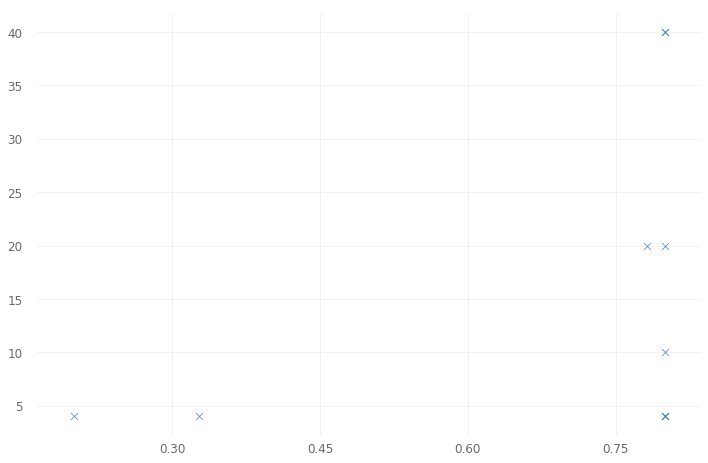

In [33]:
# a regression plot for two dimensions 
r.plot_regs("val_acc", "epochs")

None


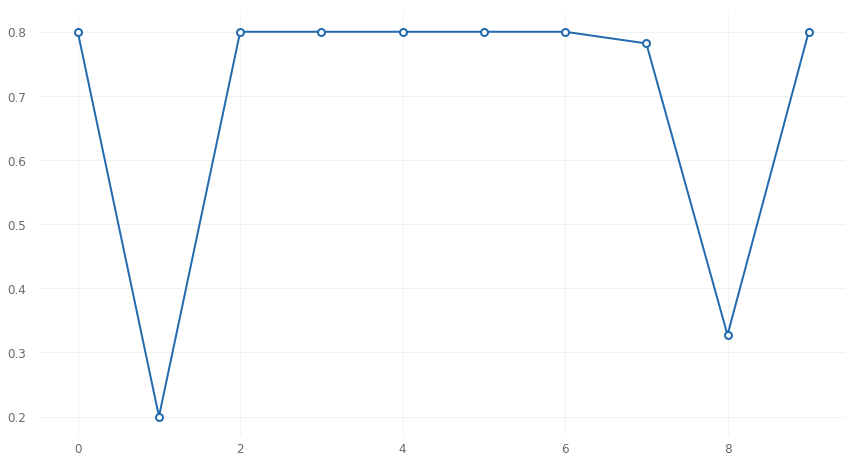

In [50]:
# line plot
print(r.plot_line("val_acc"))

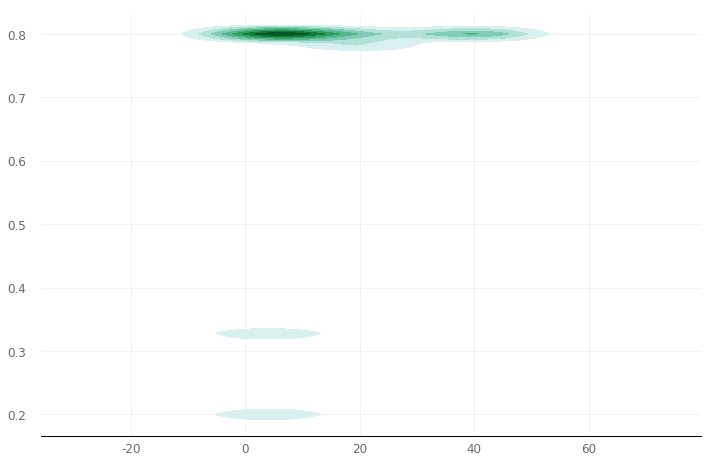

In [43]:
# up to two dimensional kernel density estimator
r.plot_kde("epochs","val_acc")

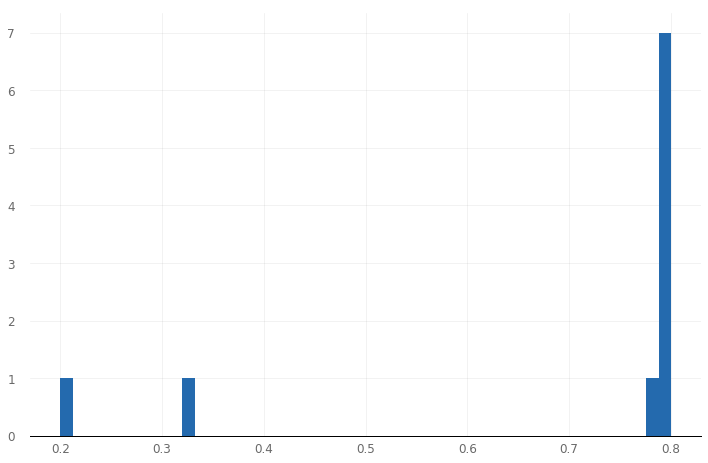

In [44]:
# a simple histogram
r.plot_hist(bins=50)

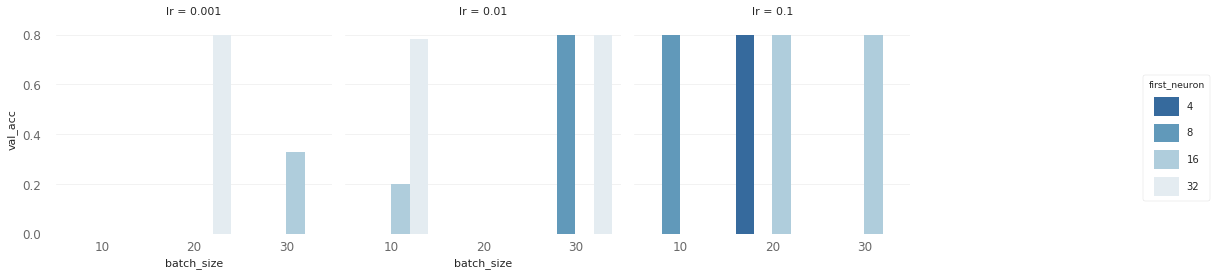

In [45]:
# a four dimensional bar grid
r.plot_bars('batch_size', 'val_acc', 'first_neuron', 'lr')


In [66]:
e = ta.Evaluate(h)

e.evaluate(x=x_test, y=y_test,
           folds=10,
           shuffle=True,
           metric='val_acc',
           mode='binary',
           print_out=True)

mean : 0.00 
 std : 0.00


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [0]:
from talos import Predict

p = Predict(h)

In [73]:
# returns predictions for input x
p.predict_classes(x_test, metric='fmeasure_acc')

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

# Resources
- Talos example:  https://nbviewer.jupyter.org/github/autonomio/talos/blob/master/examples/Hyperparameter%20Optimization%20on%20Keras%20with%20Breast%20Cancer%20Data.ipynb